In [1]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from cellrank.estimators import GPCCA
import matplotlib.pyplot as plt
import scanpy.external as sce
import scrublet as scr
#import pyranges as pr
import seaborn as sns
import cellrank as cr
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import collections
import matplotlib
#import pyBigWig
#import networkx
#import pyscenic
import requests
#import network
#import fsspec
import anndata
#import igraph
import scvi
import h5py
import desc 
import umap
import sys
import re
import os


%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)

plt.rcParams.update({'font.size': 9})
sc.set_figure_params(figsize=(2, 2), format = 'svg', dpi_save = 300)


Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


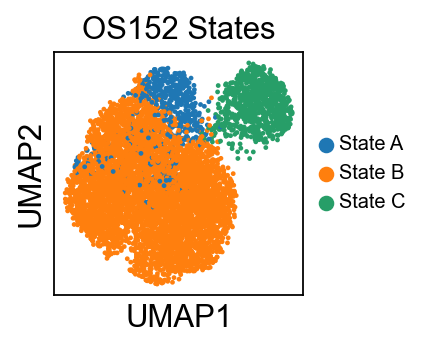

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")




# Plotting based on UMAP
sc.pl.umap(adata, 
           color=['State'], 
           legend_fontsize=9, 
           title="OS152 States",
           show=False)  # Prevent the figure from displaying immediately


# Save the figure manually to Desktop
plt.savefig('/Users/brendamelano/Desktop/UMAP_OS152_State.svg', format='svg', dpi=300)

In [4]:
# Suppose the cell population information is stored in 'cell_type' column
cell_population = 'Your_Cell_Population_Name'

# Subset the Anndata object
adata_subset = adata[adata.obs['State'] == "State A"]


# Get the expression matrix (cells x genes)
# Depending on your data, this might be stored in adata.X, adata.raw.X, or adata.layers
expression_matrix = adata_subset.X  # This is usually a sparse matrix

# Convert to a dense matrix if needed
import numpy as np
if not isinstance(expression_matrix, np.ndarray):
    expression_matrix = expression_matrix.toarray()

# Get gene names or IDs
gene_ids = adata_subset.var['gene_ids'] if 'gene_ids' in adata_subset.var.columns else adata_subset.var_names

# Get cell IDs (optional)
cell_ids = adata_subset.obs_names


# Compute mean expression across cells
mean_expression = np.mean(expression_matrix, axis=0)  # Result is a 1D array of length equal to number of genes


In [9]:
# Create a DataFrame
scRNA_expr = pd.DataFrame({
    'gene_id': gene_ids,
    'expression': mean_expression
})

# If gene_ids is an index, reset it
scRNA_expr.reset_index(inplace=True, drop=True)


In [20]:
# Load gene annotation data
gene_annotations = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gencode.v46.basic.annotation.gtf', sep='\t', comment='#', header=None,
                               names=['chrom', 'source', 'feature', 'start', 'end', 'score',
                                      'strand', 'frame', 'attribute'])

# Filter for gene features
genes = gene_annotations[gene_annotations['feature'] == 'gene']

# Extract gene_id and remove version numbers
def extract_gene_id(attribute):
    match = re.search('gene_id "([^"]+)"', attribute)
    if match:
        gene_id = match.group(1)
        # Remove version number if present
        gene_id = gene_id.split('.')[0]
        return gene_id
    else:
        return None

genes['gene_id'] = genes['attribute'].apply(extract_gene_id)

In [22]:
genes

,chrom,source,feature,start,end,score,strand,frame,attribute,gene_id
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; gene_type ""lncRNA...",ENSG00000290825
5,chr1,HAVANA,gene,12010,13670,.,+,.,"gene_id ""ENSG00000223972.6""; gene_type ""transc...",ENSG00000223972
13,chr1,HAVANA,gene,14696,24886,.,-,.,"gene_id ""ENSG00000227232.6""; gene_type ""unproc...",ENSG00000227232
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""...",ENSG00000278267
28,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA...",ENSG00000243485
...,...,...,...,...,...,...,...,...,...,...
2024867,chrM,ENSEMBL,gene,14149,14673,.,-,.,"gene_id ""ENSG00000198695.2""; gene_type ""protei...",ENSG00000198695
2024872,chrM,ENSEMBL,gene,14674,14742,.,-,.,"gene_id ""ENSG00000210194.1""; gene_type ""Mt_tRN...",ENSG00000210194
2024875,chrM,ENSEMBL,gene,14747,15887,.,+,.,"gene_id ""ENSG00000198727.2""; gene_type ""protei...",ENSG00000198727
2024880,chrM,ENSEMBL,gene,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; gene_type ""Mt_tRN...",ENSG00000210195


In [23]:
# Extract gene_name from the attribute column
def extract_gene_name(attribute):
    match = re.search('gene_name "([^"]+)"', attribute)
    return match.group(1) if match else None

genes['gene_name'] = genes['attribute'].apply(extract_gene_name)


In [24]:
genes

,chrom,source,feature,start,end,score,strand,frame,attribute,gene_id,gene_name
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; gene_type ""lncRNA...",ENSG00000290825,DDX11L2
5,chr1,HAVANA,gene,12010,13670,.,+,.,"gene_id ""ENSG00000223972.6""; gene_type ""transc...",ENSG00000223972,DDX11L1
13,chr1,HAVANA,gene,14696,24886,.,-,.,"gene_id ""ENSG00000227232.6""; gene_type ""unproc...",ENSG00000227232,WASH7P
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""...",ENSG00000278267,MIR6859-1
28,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA...",ENSG00000243485,MIR1302-2HG
...,...,...,...,...,...,...,...,...,...,...,...
2024867,chrM,ENSEMBL,gene,14149,14673,.,-,.,"gene_id ""ENSG00000198695.2""; gene_type ""protei...",ENSG00000198695,MT-ND6
2024872,chrM,ENSEMBL,gene,14674,14742,.,-,.,"gene_id ""ENSG00000210194.1""; gene_type ""Mt_tRN...",ENSG00000210194,MT-TE
2024875,chrM,ENSEMBL,gene,14747,15887,.,+,.,"gene_id ""ENSG00000198727.2""; gene_type ""protei...",ENSG00000198727,MT-CYB
2024880,chrM,ENSEMBL,gene,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; gene_type ""Mt_tRN...",ENSG00000210195,MT-TT


In [25]:
# Create a mapping from gene_name to gene_id
gene_name_to_id = genes[['gene_name', 'gene_id']].drop_duplicates()

# Prepare the scRNA expression DataFrame
scRNA_expr = pd.DataFrame({
    'gene_name': gene_ids,
    'expression': mean_expression
}).reset_index(drop=True)

# Merge to get Ensembl IDs
scRNA_expr = pd.merge(scRNA_expr, gene_name_to_id, on='gene_name', how='left')


In [26]:
scRNA_expr

,gene_name,expression,gene_id
0,MXRA8,-0.198524,ENSG00000162576
1,CCNL2,-0.039980,ENSG00000221978
2,NADK,0.009001,ENSG00000008130
3,CEP104,0.020830,ENSG00000116198
4,KLHL21,0.008817,ENSG00000162413
...,...,...,...
3002,HMGB3,-0.620248,ENSG00000029993
3003,BGN,0.137525,ENSG00000182492
3004,EMD,-0.071743,ENSG00000102119
3005,RPL10,0.114517,ENSG00000147403


In [27]:
# Exclude genes without a mapping
scRNA_expr = scRNA_expr.dropna(subset=['gene_id'])


In [28]:
# Merge expression data with gene coordinates
expr_with_coords = pd.merge(scRNA_expr, genes[['chrom', 'start', 'end', 'gene_id']],
                            on='gene_id', how='inner')


In [29]:
expr_with_coords

,gene_name,expression,gene_id,chrom,start,end
0,MXRA8,-0.198524,ENSG00000162576,chr1,1352689,1361777
1,CCNL2,-0.039980,ENSG00000221978,chr1,1385711,1399335
2,NADK,0.009001,ENSG00000008130,chr1,1751232,1780457
3,CEP104,0.020830,ENSG00000116198,chr1,3812086,3857396
4,KLHL21,0.008817,ENSG00000162413,chr1,6590724,6614607
...,...,...,...,...,...,...
2957,HMGB3,-0.620248,ENSG00000029993,chrX,150980509,150990771
2958,BGN,0.137525,ENSG00000182492,chrX,153494980,153509546
2959,EMD,-0.071743,ENSG00000102119,chrX,154379273,154381574
2960,RPL10,0.114517,ENSG00000147403,chrX,154389955,154409168


In [33]:
# Assume expr_with_coords is your DataFrame
# Ensure columns are correctly typed
expr_with_coords['Chromosome'] = expr_with_coords['chrom'].astype(str)
expr_with_coords['Start'] = expr_with_coords['start'].astype(int)
expr_with_coords['End'] = expr_with_coords['end'].astype(int)
expr_with_coords['expression'] = expr_with_coords['expression'].astype(float)


In [35]:
expr_with_coords

,gene_name,expression,gene_id,chrom,start,end,Chromosome,Start,End
0,MXRA8,-0.198524,ENSG00000162576,chr1,1352689,1361777,chr1,1352689,1361777
1,CCNL2,-0.039980,ENSG00000221978,chr1,1385711,1399335,chr1,1385711,1399335
2,NADK,0.009001,ENSG00000008130,chr1,1751232,1780457,chr1,1751232,1780457
3,CEP104,0.020830,ENSG00000116198,chr1,3812086,3857396,chr1,3812086,3857396
4,KLHL21,0.008817,ENSG00000162413,chr1,6590724,6614607,chr1,6590724,6614607
...,...,...,...,...,...,...,...,...,...
2957,HMGB3,-0.620248,ENSG00000029993,chrX,150980509,150990771,chrX,150980509,150990771
2958,BGN,0.137525,ENSG00000182492,chrX,153494980,153509546,chrX,153494980,153509546
2959,EMD,-0.071743,ENSG00000102119,chrX,154379273,154381574,chrX,154379273,154381574
2960,RPL10,0.114517,ENSG00000147403,chrX,154389955,154409168,chrX,154389955,154409168


In [36]:
import pyranges as pr

# Create a PyRanges object from your DataFrame
expr_ranges = pr.PyRanges(expr_with_coords[['Chromosome', 'Start', 'End', 'expression']])


In [37]:
expr_ranges

,Chromosome,Start,End,expression
0,chr1,1352689,1361777,-0.198524
1,chr1,1385711,1399335,-0.039980
2,chr1,1751232,1780457,0.009001
3,chr1,3812086,3857396,0.020830
4,chr1,6590724,6614607,0.008817
...,...,...,...,...
2957,chrX,153494980,153509546,0.137525
2958,chrX,154379273,154381574,-0.071743
2959,chrX,154389955,154409168,0.114517
2960,chrX,155071420,155123077,-0.118085


In [40]:
# Define bin size (e.g., 20,000 bp)
bin_size = 20000

# Get unique chromosomes from your data
chromosomes = expr_ranges.Chromosome.unique()

# Create bins for each chromosome
binned_ranges_list = []

for chrom in chromosomes:
    # Get the maximum end position for the chromosome
    max_end = expr_ranges[expr_ranges.Chromosome == chrom].End.max()
    # Create bins for the chromosome
    bins = pr.from_dict({
        'Chromosome': chrom,
        'Start': np.arange(0, max_end + bin_size, bin_size),
        'End': np.arange(bin_size, max_end + bin_size * 2, bin_size)
    })
    binned_ranges_list.append(bins)

# Combine all bins into a single PyRanges object
bins = pr.concat(binned_ranges_list)


In [42]:
# Intersect expression ranges with bins and sum expression values
binned_expression = bins.join(expr_ranges, strandedness=False).df

# Sum expression within each bin
binned_expression = binned_expression.groupby(['Chromosome', 'Start', 'End']).agg({'expression': 'sum'}).reset_index()


In [48]:
binned_expression

,Chromosome,Start,End,expression
0,chr1,920000,940000,-0.040823
1,chr1,940000,960000,-0.040823
2,chr1,1000000,1020000,0.144386
3,chr1,1340000,1360000,-0.198524
4,chr1,1360000,1380000,-0.198524
...,...,...,...,...
18645,chrX,155640000,155660000,0.027642
18646,chrX,155660000,155680000,0.027642
18647,chrX,155680000,155700000,0.027642
18648,chrX,155700000,155720000,0.027642


In [ ]:
import pyBigWig

In [53]:
# Create a DataFrame for all bins
all_bins_df = bins.df[['Chromosome', 'Start', 'End']].drop_duplicates()

# Merge with binned_expression
final_expression = pd.merge(all_bins_df, binned_expression, on=['Chromosome', 'Start', 'End'], how='left')

# Replace NaN expression values with zero
final_expression['Expression'] = final_expression['expression'].fillna(0)


In [55]:


# Load chromosome sizes for the GRCh38/hg38 human genome assembly
chrom_sizes = {
    'chr1': 248956422,
    'chr2': 242193529,
    'chr3': 198295559,
    'chr4': 190214555,
    'chr5': 181538259,
    'chr6': 170805979,
    'chr7': 159345973,
    'chr8': 145138636,
    'chr9': 138394717,
    'chr10': 133797422,
    'chr11': 135086622,
    'chr12': 133275309,
    'chr13': 114364328,
    'chr14': 107043718,
    'chr15': 101991189,
    'chr16': 90338345,
    'chr17': 83257441,
    'chr18': 80373285,
    'chr19': 58617616,
    'chr20': 64444167,
    'chr21': 46709983,
    'chr22': 50818468,
    'chrX': 156040895,
    'chrY': 57227415
    # 'chrM' (mitochondrial DNA) can be included if needed
}

# Create a bigWig file
bw = pyBigWig.open('scRNA_signal.bw', 'w')
bw.addHeader(list(chrom_sizes.items()))

# Prepare data for writing
chroms = final_expression['Chromosome'].tolist()
starts = final_expression['Start'].astype(int).tolist()
ends = final_expression['End'].astype(int).tolist()
values = final_expression['expression'].astype(float).tolist()

# Write to bigWig
bw.addEntries(chroms, starts, ends=ends, values=values)

bw.close()


In [56]:

# Open the bigWig file
bw = pyBigWig.open('scRNA_signal.bw')

# Get chromosome sizes
chrom_sizes = bw.chroms()

# Print chromosome names and sizes
print("Chromosome Sizes:")
for chrom, size in chrom_sizes.items():
    print(f"{chrom}: {size}")

# Set a limit on the number of intervals to print per chromosome
interval_limit = 10

# Iterate over all chromosomes and print intervals
for chrom in chrom_sizes.keys():
    print(f"\nIntervals for {chrom}:")
    intervals = bw.intervals(chrom)
    if intervals:
        for i, interval in enumerate(intervals):
            if i >= interval_limit:
                print(f"... ({len(intervals) - interval_limit} more intervals)")
                break
            start, end, value = interval
            print(f"{chrom}\t{start}\t{end}\t{value}")
    else:
        print(f"No intervals found for {chrom}")

# Close the bigWig file
bw.close()

Chromosome Sizes:
chr1: 248956422
chr2: 242193529
chr3: 198295559
chr4: 190214555
chr5: 181538259
chr6: 170805979
chr7: 159345973
chr8: 145138636
chr9: 138394717
chr10: 133797422
chr11: 135086622
chr12: 133275309
chr13: 114364328
chr14: 107043718
chr15: 101991189
chr16: 90338345
chr17: 83257441
chr18: 80373285
chr19: 58617616
chr20: 64444167
chr21: 46709983
chr22: 50818468
chrX: 156040895
chrY: 57227415

Intervals for chr1:
chr1	0	20000	nan
chr1	20000	40000	nan
chr1	40000	60000	nan
chr1	60000	80000	nan
chr1	80000	100000	nan
chr1	100000	120000	nan
chr1	120000	140000	nan
chr1	140000	160000	nan
chr1	160000	180000	nan
chr1	180000	200000	nan
... (12434 more intervals)

Intervals for chr2:
chr2	0	20000	nan
chr2	20000	40000	nan
chr2	40000	60000	nan
chr2	60000	80000	nan
chr2	80000	100000	nan
chr2	100000	120000	nan
chr2	120000	140000	nan
chr2	140000	160000	nan
chr2	160000	180000	nan
chr2	180000	200000	nan
... (12076 more intervals)

Intervals for chr3:
chr3	0	20000	nan
chr3	20000	40000	nan
chr3